# Numerical Methods of Solving ODEs


Things to add:  
    - Discussion about machine epsilon and number representation by computers  
    - Label equations with numbers  
    - Global vs local error

**The goal of this jupyter notebook is to introduce you to how numerical methods for solution of ordinary differential equations (ODEs) work in general and review various option of SciPy solve_ivp() function. This is a math heavy subject but it's important to have a basic idea of how ODE solvers like solve_ivp() actually work.**

In [2]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Example: Clearance of drugs from the blood

We will use drug clearance from the blood through kidney filtration as an example in this section.
Drug clearance from the blood can be describe using differential equation $\frac{d[Drug]}{dt}=-k[Drug]$, where $t$ is time,  k is some constant specific describing kindey filtration rate,  $[Drug](t)$ is blood concentration of drug at time $t$ and $[Drug]_0$ is is blood concentration of drug at $t=0$. 

We can solve $\frac{d[Drug]}{dt}=-k[Drug]$ numerically using solve_ivp() from SciPy library.

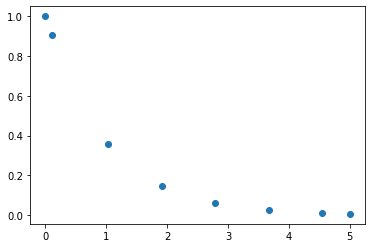

In [77]:
k = 1
Drug_0 = [1]
tspan = [0, 5]


def fun(t, y):
    dDrug_dt = -k * y
    return dDrug_dt


soln = solve_ivp(fun, tspan, Drug_0) # add t_eval=np.linspace(0, 5, 1000) to get more points
plt.scatter(soln.t, soln.y[0]);

$\frac{d[Drug]}{dt}=-k[Drug]$ is simple enough so that we can also solve it analytically using dsolve() function from SymPy library:

In [5]:
Drug = sym.symbols("[Drug]", cls=sym.Function)
t, k, Drug_0 = sym.symbols("t, k, [Drug]_0")
sym.dsolve(sym.diff(Drug(t), t) + k * Drug(t), Drug(t), ics={Drug(0): Drug_0})

Eq([Drug](t), [Drug]_0*exp(-k*t))

# Numerical solution of $\frac{d[Drug]}{dt}=-k[Drug]$

Now, let's write code to solve $\frac{d[Drug]}{dt}=-k[Drug]$ without using solve_ivp() function with the goal of better understanding how solve_ivp() and similar methods actually works.

### Euler method

The basic idea behind numerical methods for solving ODEs is to simply take some small number for $\Delta t$ and do repetitive algebraic calculation with it.  
For example, let't take some value of $\Delta t$ and find a solution for $\frac{d[Drug]}{dt}=-k[Drug]$ starting from initial $[Drug]_0$  
  
First, we rewrite $\frac{d[Drug]}{dt}=-k[Drug]$ as $\frac{\Delta[Drug]}{\Delta t}=\frac{[Drug]_{t+\Delta t}-[Drug]_{t}}{\Delta t}=-k[Drug]$.  
  
Next, we can use our initial condition $[Drug]_{t=0}=[Drug]_0$ to find $[Drug]_{\Delta t}$:  
  
$[Drug]_{\Delta t}=[Drug]_0-\Delta t \cdot k \cdot [Drug]_0=[Drug]_0 \cdot (1-\Delta t \cdot k)$  
  
Repeat the same to get $[Drug]_{2 \cdot \Delta t}$, $[Drug]_{3 \cdot \Delta t}$ ... etc:  
  
$[Drug]_{2 \cdot \Delta t}=[Drug]_{\Delta t}-\Delta t \cdot k \cdot [Drug]_{\Delta t}=[Drug]_0 \cdot (1-\Delta t \cdot k)^2$  
  
$[Drug]_{3 \cdot \Delta t}=[Drug]_0 \cdot (1-\Delta t \cdot k)^3$... etc etc etc for as many $\Delta t$ steps as we want.   
  
This is called the explicit Euler method and is the simplest method that can be used to numerically solve ODEs although it is rarely used in practice as there are more efficient methods as we will review below.  
Lets implement Euler method with python code.

### For loops

We will need to use a *for loop* to implement Euler method.  
*For loops* are very common in computer programs and is a way to make computer do a repetitive task like Euler method.  
Here's a simple example of a *for loop*:

In [9]:
for i in range(5):
    print(i)

0
1
2
3
4


Note that numbering in python starts at 0 as opposed to 1 and that last number (i.e. 5 above) is not included

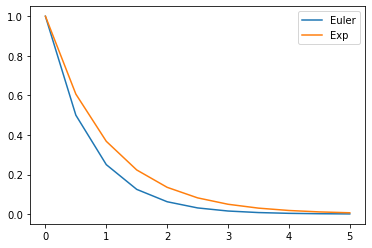

In [52]:
Drug = [1,]
time = [0,]
dt = 0.5
k = 1
for t in range(1, 11):
    Drug = np.append(Drug, Drug[t - 1] - dt * k * Drug[t - 1])
    time = np.append(time, time[t - 1] + dt)

plt.plot(time, Drug,label='Euler')
plt.plot(time, np.exp(-k*time),label='Exp')
plt.legend();

Note that you have to choose $\Delta t$ carefully as $\Delta t$>2 will produce an unstable solution because if $|1-\Delta t \cdot k|>1$ than numerical solution will go to $\infty$ if number of steps goes to $\infty$.  
In addition, the closer $\Delta t$ is to 0 the closer is our solution to $Drug(t)=Drug_0e^{-kt}$  .

### Error of numerical methods

All numerical methods are approximations of the analytical solution and the error of numerical methods is the difference between numerical solution and analytical solution.  
  
  Let's analyze the error introduced by Euler method above and find how error depends on $\Delta t$.

One way to analyze the magnitude of error introduced by Euler method is by using Taylor series.  
You likely learned about Taylor series in intro calculus: https://en.wikipedia.org/wiki/Taylor_series.   
  
  Taylor series is the following equation and is key for many numerical ODE methods:  
  
  $y(t+\Delta t)=y(t)+\Delta t \frac{dy(t)}{dt} + \frac {\Delta t^2}{2} \frac{d^2y(t)}{dt^2} + ... + \frac{\Delta t^n}{n!} \frac{d^ny(t)}{dt^n}$  
  
  Taylor series is more and more accurate at higher $n$ and is exact to $n \rightarrow \infty$
  
  In our case, Taylor series will look like this:  
  
  $[Drug]_{t+\Delta t}=[Drug]_{t}+\Delta t \frac{d[Drug]}{dt} + \frac {\Delta t^2}{2} \frac{d^2[Drug]}{dt^2} + ... + \frac{\Delta t^n}{n!} \frac{d^n[Drug]}{dt^n}$  
  
  Since we know that $\frac{d[Drug]}{dt}=-k[Drug]$ and $k=1$:  
  
  $[Drug]_{t+\Delta t}=[Drug]_{t}-\Delta t [Drug]_{t} + \frac {\Delta t^2}{2} [Drug]_{t} + ... + \frac{\Delta t^n}{n!} [Drug]_{t}$  
  
Note that Euler method *truncates* the Taylor series at the second component so the error of Euler method will be equal to  
  
  $O(\Delta t^2)=\frac {\Delta t^2}{2} [Drug]_{t} + ... + \frac{\Delta t^n}{n!} [Drug]_{t}$  
  
  and the equation is often written as:  
  
$[Drug]_{t+\Delta t}=[Drug]_{t}-\Delta t [Drug]_{t} + O(\Delta t^2)$  
  
  So the error per step is proportinal to $\Delta t^2$ and total error after time $t$ is proportinal to $N_{Steps} \cdot \Delta t^2$  

### Taylor method

  Let's see if we can improve Euler method if we truncate at third or fourth term of Taylor series:

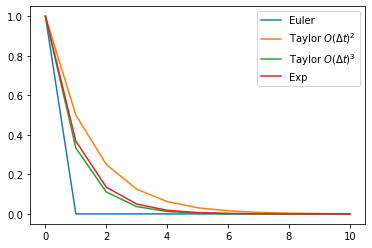

In [46]:
Drug = [1,]
Drug2 = [1,]
Drug3 = [1,]
time = [0,]
dt = 1
k = 1
for t in range(1, 11):
    Drug = np.append(Drug, Drug[t - 1] - dt * k * Drug[t - 1])
    Drug2 = np.append(Drug2, Drug2[t - 1] - dt * k * Drug2[t - 1] + Drug2[t - 1]/2*(dt*k)**2)
    Drug3 = np.append(Drug3, Drug3[t - 1] - dt * k * Drug3[t - 1] + Drug3[t - 1]/2*(dt*k)**2 - Drug3[t - 1]/6*(dt*k)**3)
    time = np.append(time, time[t - 1] + dt)

plt.plot(time, Drug,label='Euler')
plt.plot(time, Drug2,label='Taylor $O(Δt)^2$')
plt.plot(time, Drug3,label='Taylor $O(Δt)^3$')
plt.plot(time, np.exp(-k*time),label='Exp')
plt.legend();


This method is also rarely used in practice as it can be difficult to compute $\frac{d^ny(t)}{dt^n}$ for $n>1$

### Runge-Kutta method

Finally, here we'll implement numerical ODE solver method that is actually used in practice.  
Learn more about Runge-Kutta methods if interested: https://en.wikipedia.org/wiki/Runge–Kutta_methods  
The basic idea behind Runge-Kutta methods is to use a trick so that we can use Taylor method without calculating $\frac{d^ny(t)}{dt^n}$  
  
  Let's assume we have ODE $\frac{y(t)}{dt}=f(t,y(t))$.  
  
  Taylor series for $y(t+\Delta t)$:  
  
$y(t+\Delta t)=y(t)+\Delta t \cdot f(t,y(t)) + \frac {\Delta t^2}{2} \frac{df(t,y(t))}{dt} + O(\Delta t^3)$
 
  
  Remember that $\frac{df(t,y(t))}{dt} = f(t,y(t))\frac{\partial f(t,y(t))}{\partial y} + \frac{\partial f(t,y(t))}{\partial t}$ so Taylor series can be explanded to:  
  
  $y(t+\Delta t)=y(t) + \Delta t  \cdot f(t, y(t)) + \frac{\Delta t^2}{2}f(t,y(t))\frac{df(t,y(t))}{dy} + \frac{\Delta t^2}{2}\frac{df(t,y(t))}{dt} + O(\Delta t^3)$  


  The basic idea of Runge-Kutta method is to approximate $y(t+\Delta t)$ using the following equation:  
  
  $y(t+\Delta t)=y(t)+ \Delta t \cdot f(t+a \cdot h, y(t)+a \cdot h \cdot f(t,y(t)))$  
  
  Now we need to find the values of $a$ so that the above equation is analogous to Taylor method with truncation error $O(\Delta t^3)$  
  To do this we can make a Taylor expansion of the above approximation:  
  
  $f(t+a \cdot \Delta t, y(t)+a \cdot \Delta t \cdot f(t,y(t))) = f(t,y(t)) + a \cdot \Delta t \frac{df(t,y(t))}{dt} + a \cdot \Delta t \cdot f(t,y(t))\frac{df(t,y(t))}{dy} + O(\Delta t^2)$  
  
  Substituting above into the Runge-Kutta approximation we get:  
  
  $y(t+\Delta t)=y(t) + \Delta t \cdot f(t,y(t)) + a \cdot \Delta t^2 \cdot f(t,y(t))\frac{df(t,y(t))}{dy} + a \cdot \Delta t^2\frac{df(t,y(t))}{dt} + O(\Delta t^3)$  
  
  Comparing $y(t+\Delta t)$ with Runge-Kutta approximation and actual Taylor series we can see that $a=\frac{1}{2}$ is the solution.



Let's implement Runge-Kutta method.

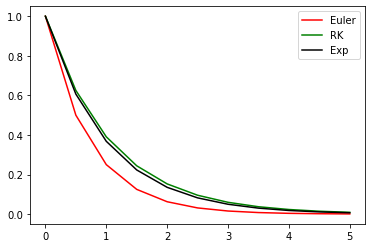

In [51]:
Drug = [1,]
Drug2 = [1,]
Drug_RK = [1,]
time = [0,]
dt = 0.5
k = 1
for t in range(1, 11):
    Drug = np.append(Drug, Drug[t - 1] - dt * k * Drug[t - 1])
    Drug_RK = np.append(Drug_RK, Drug_RK[t - 1] - dt * k * (Drug_RK[t - 1]- 0.5* dt * k* Drug_RK[t - 1]))
    time = np.append(time, time[t - 1] + dt)

plt.plot(time, Drug, color='red',label='Euler')
plt.plot(time, Drug_RK, color='green',label='RK')
plt.plot(time, np.exp(-k*time), color='black',label='Exp')
plt.legend();

Runge-Kutta methods were developed in early 1900s!  
  
**Many more methods have been described (and are continuing to be described) to numerically solve differential equations including higher order Runge-Kutta methods as well as completely different methods.**  
  
**You can take whole courses describing various numerical methods which are beyond the scope of this one lecture but the principle is similar to Euler, Taylor and Runge-Kutta methods described above.**

# SciPy solve_ivp()

The great thing about SciPy *solve_ivp()* is that you don't have to implement complex numerical algorithms yourself as we did above because *solve_ivp()* already has many algorithms implemented and you can just use them without fully understanding how they work but hopefully you have some idea from discussion above.

In [60]:
solve_ivp?

Signature:
solve_ivp(
    fun,
    t_span,
    y0,
    method='RK45',
    t_eval=None,
    dense_output=False,
    events=None,
    vectorized=False,
    args=None,
    **options,
)
Docstring:
Solve an initial value problem for a system of ODEs.

This function numerically integrates a system of ordinary differential
equations given an initial value::

    dy / dt = f(t, y)
    y(t0) = y0

Here t is a 1-D independent variable (time), y(t) is an
N-D vector-valued function (state), and an N-D
vector-valued function f(t, y) determines the differential equations.
The goal is to find y(t) approximately satisfying the differential
equations, given an initial value y(t0)=y0.

Some of the solvers support integration in the complex domain, but note
that for stiff ODE solvers, the right-hand side must be
complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
To solve a problem in the complex domain, pass y0 with a complex data type.
Another option always available is to rewrite your pro

# Include events in solve_ivp() to show repeated dosing with the drug and discuss how to choose the right dose that is not too high or too low by drawing dotted line for dose limiting toxicity and minimal efficatious dose